In [1]:
from model.model import IndexModel, SyntacticIndex, SemanticIndex

import json
from utils.utils import loadCorpus, saveCorpus, load_dictprop, getTmpDictProp, save_dataset, load_dataset, prepare_corpus, vectorize_data, showEval, evaluate_models, nereval2df, nerevaltype2df
import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from collections import Counter, defaultdict


import joblib
import os

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%load_ext autoreload
%autoreload 2
n_core = 6

In [2]:
tags = ['PER', 'LOC', 'TIME', 'MISC']
dict_ent = {
    'Q5': 'PER',
    'Property:P625': 'LOC',
    'time': 'TIME',
    'Misc': 'MISC',
    'pers': 'PER',
    'loc': 'LOC',
    'time': 'TIME',
    'X': 'MISC'
}

In [3]:
project = f'../data/Q5-Property:P625'

with open(f"{project}/entity_types.json", 'r', encoding='utf-8') as f:
    entitytype = json.load(f)


list_entitytype = list(entitytype.keys())

print(project)

dict_prop = load_dictprop(project)
tmp_dict = getTmpDictProp(dict_prop=dict_prop)

dict_prop, tmp_dict

../data/Q5-Property:P625


([{'type': 'Q5',
   'name': 'person',
   'props': {'P19': 'placeOfBirth',
    'P569': 'dateOfBirth',
    'P570': 'dateOfDeath',
    'P26': 'spouse',
    'P106': 'occupation',
    'P69': 'educatedAt',
    'P17': 'country',
    'P571': 'inception',
    'P1376': 'capitalOf',
    'P6': 'headOfGoverment',
    'P47': 'sharesBordersWith',
    'P463': 'memberOf',
    'P206': 'nextInBodyWater',
    'Other': 'Other'}},
  {'type': 'Property:P625',
   'name': 'location',
   'props': {'P17': 'country',
    'P571': 'inception',
    'P1376': 'capitalOf',
    'P6': 'headOfGoverment',
    'P47': 'sharesBordersWith',
    'P463': 'memberOf',
    'P206': 'nextInBodyWater'}}],
 {'P19': 'placeOfBirth',
  'P569': 'dateOfBirth',
  'P570': 'dateOfDeath',
  'P26': 'spouse',
  'P106': 'occupation',
  'P69': 'educatedAt',
  'P17': 'country',
  'P571': 'inception',
  'P1376': 'capitalOf',
  'P6': 'headOfGoverment',
  'P47': 'sharesBordersWith',
  'P463': 'memberOf',
  'P206': 'nextInBodyWater',
  'Other': 'Other'}

In [4]:
tmp_dict

{'P19': 'placeOfBirth',
 'P569': 'dateOfBirth',
 'P570': 'dateOfDeath',
 'P26': 'spouse',
 'P106': 'occupation',
 'P69': 'educatedAt',
 'P17': 'country',
 'P571': 'inception',
 'P1376': 'capitalOf',
 'P6': 'headOfGoverment',
 'P47': 'sharesBordersWith',
 'P463': 'memberOf',
 'P206': 'nextInBodyWater',
 'Other': 'Other'}

## Prepare dataset

In [4]:
clean = True
corpus = loadCorpus(project, clean=clean)
len(corpus), corpus[0]

(1627,
 {'id': 'Q100',
  'content': [{'sent': 'Les seize sites officiels de ce parcours sont :',
    'sent_i': 0,
    'props': [{'prop': 'Other',
      'sent': 'Les seize sites officiels de ce parcours sont :',
      'source': 'NO-SOURCE',
      'target': 'NO-TARGET',
      'sdpgraphs': [{'sourceNode': None,
        'targetNode': None,
        'sourceNodeRoot': None,
        'targetNodeRoot': None,
        'sdpgraph': <networkx.classes.digraph.DiGraph at 0x17b33edd0>}]}],
    'head': 7,
    'graph': <networkx.classes.digraph.DiGraph at 0x17097b2d0>},
   {'sent': "Après la Guerre d’indépendance, comme New York, Baltimore et la capitale fédérale Philadelphie, Boston accueille l'une des 4 bourses rivales des États-Unis, même si Philadelphie puis New-York vont tirer leur épingle du jeu financier.",
    'sent_i': 5,
    'props': [{'prop': 'P17',
      'sent': "Après la Guerre d’indépendance, comme New York, Baltimore et la capitale fédérale Philadelphie, Boston accueille l'une des 4 bourses

In [5]:
params = {
    "corpus": corpus,
    "train_size": 1,
    "dev_size": 0,
    "clean": True
    # "maxsize": 200000
}
data = prepare_corpus(**params)
# print(len(list_graphs))
# list_graphs[0]
try:
    print(len(data['X_train']), len(data['X_dev']), len(data['X_test']))
except:
    print(len(data['X_train']), len(data['y_train']))


6704 6704


In [6]:
cc_dict = defaultdict(int)
# limit = 303
limit = 313
filtered_data = {
    "X_train": [],
    "y_train": []
}
for i, y in enumerate(data['y_train']):
    x = data['X_train'][i]
    # y = tmp_dict[y]
    if cc_dict[y] < limit:
        cc_dict[y] += 1
        filtered_data['X_train'].append(x)
        filtered_data['y_train'].append(y)

data = filtered_data


In [7]:
c = Counter([tmp_dict[y] for y in data['y_train']])
print(pd.Series(dict(c.most_common())).to_frame().to_latex())

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
country & 313 \\
sharesBordersWith & 313 \\
nextInBodyWater & 313 \\
capitalOf & 313 \\
headOfGoverment & 313 \\
memberOf & 313 \\
inception & 313 \\
placeOfBirth & 313 \\
dateOfBirth & 313 \\
occupation & 313 \\
spouse & 313 \\
dateOfDeath & 313 \\
educatedAt & 313 \\
\bottomrule
\end{tabular}



In [8]:
evalpath = f'../data/Q5-Property:P625-clean'
clean = True
evalcorpus = loadCorpus(evalpath, clean=clean)

params = {
    "corpus": evalcorpus,
    "train_size": .5,
    "dev_size": 0,
    "clean": True
    # "maxsize": 200000
}
evaldata = prepare_corpus(**params)
print(len(evaldata['X_dev']), len(evaldata['X_test']))

604 605


In [9]:
c = Counter([tmp_dict[y] for y in evaldata['y_test']])
print(pd.Series(dict(c.most_common())).to_frame().to_latex())

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
sharesBordersWith & 109 \\
Other & 108 \\
country & 86 \\
capitalOf & 71 \\
occupation & 63 \\
placeOfBirth & 36 \\
dateOfBirth & 33 \\
nextInBodyWater & 28 \\
dateOfDeath & 23 \\
memberOf & 20 \\
spouse & 10 \\
headOfGoverment & 8 \\
inception & 5 \\
educatedAt & 5 \\
\bottomrule
\end{tabular}



In [10]:
from gensim.models import KeyedVectors
embeddings_path = '../data/embeddings/conceptnet_fr-19.08-clean_simpler'
we = KeyedVectors.load(embeddings_path, mmap='r')

2024-02-04 22:40:36 gensim.utils INFO: loading KeyedVectors object from ../data/embeddings/conceptnet_fr-19.08-clean_simpler
2024-02-04 22:40:36 gensim.utils INFO: loading vectors from ../data/embeddings/conceptnet_fr-19.08-clean_simpler.vectors.npy with mmap=r
2024-02-04 22:40:36 gensim.utils INFO: KeyedVectors lifecycle event {'fname': '../data/embeddings/conceptnet_fr-19.08-clean_simpler', 'datetime': '2024-02-04T22:40:36.677296', 'gensim': '4.3.2', 'python': '3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [11]:
# vec_data = {
#     "X_train": vectorize_data(data['X_train'], we=we),
#     "y_train": [ml_tmp_dict[x] for x in data['y_train']],
#     "X_dev": vectorize_data(evaldata['X_dev'], we=we),
#     "y_dev": [ml_tmp_dict[x] for x in evaldata['y_dev']],
#     "X_test": vectorize_data(evaldata['X_test'], we=we),
#     "y_test": [ml_tmp_dict[x] for x in evaldata['y_test']] 
# }

vec_data = {
    "X_train": vectorize_data(data['X_train'], we=we),
    "y_train": [tmp_dict[x] for x in data['y_train']],
    "X_dev": vectorize_data(evaldata['X_dev'], we=we),
    "y_dev": [tmp_dict[x] for x in evaldata['y_dev']],
    "X_test": vectorize_data(evaldata['X_test'], we=we),
    "y_test": [tmp_dict[x] for x in evaldata['y_test']] 
}

## Train index

In [12]:
syntactic_index_params = {
    "list_graphs": data['X_train'],
    "anchor_textvalue": ['lemma', 'pos'],
    "graphkey": 'sdpgraph',
    "propkey": 'prop',
    "support": 2,
    "dict_prop": dict_prop,
    "savepath": project
}
syntacticIndex = SyntacticIndex()
syntacticIndex.trainSyntacticIndex(**syntactic_index_params)
syntacticIndex.syntacticIndex

{'abriter_VERB': [{'graph': <networkx.classes.digraph.DiGraph at 0x17d5d2c50>,
   'size': 4,
   'props': [{'name': 'sharesBordersWith', 'support': 2}],
   'ambiguous': 0,
   'source_types': ['Property:P625'],
   'source_nodes': [19],
   'target_types': ['Property:P625'],
   'target_nodes': [49],
   'ner_rules': {'sharesBordersWith': {'source_type': 'Property:P625',
     'target_type': 'Property:P625'}},
   'i': 1}],
 'accueillir_VERB': [{'graph': <networkx.classes.digraph.DiGraph at 0x17e1a6090>,
   'size': 4,
   'props': [{'name': 'capitalOf', 'support': 2}],
   'ambiguous': 0,
   'source_types': ['Property:P625'],
   'source_nodes': [0],
   'target_types': ['Property:P625'],
   'target_nodes': [7],
   'ner_rules': {'capitalOf': {'source_type': 'Property:P625',
     'target_type': 'Property:P625'}},
   'i': 1}],
 'acquérir_VERB': [{'graph': <networkx.classes.digraph.DiGraph at 0x17cb34850>,
   'size': 6,
   'props': [{'name': 'country', 'support': 2}],
   'ambiguous': 0,
   'source_ty

In [13]:
from numpy import mean

print('Unique anchors', len(syntacticIndex.syntacticIndex.keys()))
print('Unique patterns', len([y['graph'] for x in syntacticIndex.syntacticIndex.values() for y in x]))
print('Ambiguous', sum([y['ambiguous'] for x in syntacticIndex.syntacticIndex.values() for y in x ]))
print('Mean graph', mean([len(y) for x in syntacticIndex.syntacticIndex for y in x]))

Unique anchors 168
Unique patterns 322
Ambiguous 4
Mean graph 1.0


# Classification
## Index classifier

In [15]:
semantic_index_params = {
    "list_graphs": data['X_train'],
    "textvalue":  syntacticIndex.syntacticIndexParams['anchor_textvalue'],
    "dict_prop": dict_prop,
    # "savepath": project

}
base_semanticIndex = SemanticIndex()
base_semanticIndex.trainSemanticIndex(**semantic_index_params)
base_semanticIndex.semanticIndex

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1114a6d10>>
Traceback (most recent call last):
  File "/Volumes/T7/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr

NameError: name 'ngram_size' is not defined

In [17]:
print(base_semanticIndex.semanticIndex.round(decimals=3).head(n=10).to_latex())

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
CONCEPT-INDEX & occupation & capitalOf & country & placeOfBirth & nextInBodyWater & spouse & memberOf & sharesBordersWith & dateOfBirth & dateOfDeath & inception & headOfGoverment & educatedAt \\
\midrule
accueillir_VERB & 0.000000 & 0.647000 & 0.155000 & 0.000000 & 0.000000 & 0.000000 & 0.734000 & 0.135000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
un_PRON & 0.094000 & 0.045000 & 0.259000 & 0.030000 & 0.064000 & 0.091000 & 0.852000 & 0.038000 & 0.000000 & 0.000000 & 0.366000 & 0.000000 & 0.217000 \\
bourse_NOUN & 0.000000 & 0.000000 & 1.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 \\
séparer_VERB & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.984000 & 0.000000 & 0.000000 & 0.143000 & 0.000000 & 0.000000 & 0.107000 & 0.000000 & 0.000000 \\
rivière_NOUN & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 1.000000 & 0.000000 & 0.000000 & 0.000000 & 0.000000 & 0.00000

In [88]:
def getEnt(data):
    ner = []
    for x in data:
        if x['prop'] != 'Other':
            sourceNode = x['sourceNode']
            sourceType = x['source_type']
            start = sourceNode[0]
            end = sourceNode[-1] + 1

            ner.append(
                {
                            "label": sourceType,
                            "start": start,
                            "end": end
                        }
            )

            targetNode = x['sourceNode']
            targetType = x['target_type']
            start = targetNode[0]
            end = targetNode[-1] + 1

            ner.append(
                {
                            "label": targetType,
                            "start": start,
                            "end": end
                        }
            )
        else:
            ner.append(
                                                                   {
                                "label": 'Other',
                                "start": 0,
                                "end": 0
                            }
            )
    return ner 

getEnt(evaldata['X_dev'])

[{'label': 'Property:P625', 'start': 34, 'end': 35},
 {'label': 'Property:P625', 'start': 34, 'end': 35},
 {'label': 'Property:P625', 'start': 1, 'end': 2},
 {'label': 'Property:P625', 'start': 1, 'end': 2},
 {'label': 'Property:P625', 'start': 7, 'end': 8},
 {'label': 'Property:P625', 'start': 7, 'end': 8},
 {'label': 'Property:P625', 'start': 1, 'end': 3},
 {'label': 'Property:P625', 'start': 1, 'end': 3},
 {'label': 'Property:P625', 'start': 74, 'end': 75},
 {'label': 'Property:P625', 'start': 74, 'end': 75},
 {'label': 'Other', 'start': 0, 'end': 0},
 {'label': 'Property:P625', 'start': 3, 'end': 4},
 {'label': 'Property:P625', 'start': 3, 'end': 4},
 {'label': 'Property:P625', 'start': 7, 'end': 8},
 {'label': 'Property:P625', 'start': 7, 'end': 8},
 {'label': 'Property:P625', 'start': 1, 'end': 2},
 {'label': 'Property:P625', 'start': 1, 'end': 2},
 {'label': 'Other', 'start': 0, 'end': 0},
 {'label': 'Property:P625', 'start': 0, 'end': 1},
 {'label': 'Property:P625', 'start': 0,

In [18]:
models = {
    "base_semanticIndex": IndexModel(extractor=syntacticIndex, classifier=base_semanticIndex),

}
list_thresh = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]

# dev_true_y = [tmp_dict[x] for x in evaldata['y_dev']]
# test_true_y = [tmp_dict[x] for x in evaldata['y_test']]


# upper_bound = 1

eval_dict = evaluate_models(models=models, evaldata=evaldata, dict_rel=tmp_dict, dict_ent=dict_ent, ner_tags = tags,list_thresh=list_thresh)

/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classificati

In [86]:
key = 'base_semanticIndex'
eval = showEval(eval_dict, key)
# eval

# print(eval.round(decimals=3))

print(eval.round(decimals=3).to_latex())
# eval['test']

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{3}{r}{Dev} & \multicolumn{3}{r}{Test} \\
 & P & R & F1 & P & R & F1 \\
\midrule
0.000000 & 0.657000 & 0.151000 & 0.236000 & 0.630000 & 0.145000 & 0.231000 \\
0.100000 & 0.605000 & 0.146000 & 0.226000 & 0.600000 & 0.142000 & 0.225000 \\
0.200000 & 0.605000 & 0.146000 & 0.226000 & 0.600000 & 0.142000 & 0.225000 \\
0.300000 & 0.566000 & 0.141000 & 0.217000 & 0.616000 & 0.137000 & 0.217000 \\
0.400000 & 0.559000 & 0.132000 & 0.208000 & 0.616000 & 0.135000 & 0.214000 \\
0.500000 & 0.487000 & 0.118000 & 0.186000 & 0.544000 & 0.118000 & 0.187000 \\
0.600000 & 0.416000 & 0.108000 & 0.168000 & 0.464000 & 0.115000 & 0.181000 \\
0.700000 & 0.423000 & 0.094000 & 0.148000 & 0.417000 & 0.103000 & 0.163000 \\
0.800000 & 0.423000 & 0.082000 & 0.129000 & 0.417000 & 0.091000 & 0.144000 \\
0.900000 & 0.357000 & 0.072000 & 0.117000 & 0.357000 & 0.086000 & 0.138000 \\
10.000000 & 0.510000 & 0.119000 & 0.186000 & 0.526000 & 0.122000 & 0.192000 \\
\bottomrule

In [20]:
print(eval_dict['base_semanticIndex'][0]['dev']['report'])

                   precision    recall  f1-score   support

            Other      0.000     0.000     0.000         0
        capitalOf      0.714     0.071     0.130        70
          country      0.556     0.051     0.093        99
      dateOfBirth      1.000     0.250     0.400        40
      dateOfDeath      1.000     0.150     0.261        20
       educatedAt      0.600     0.375     0.462         8
  headOfGoverment      0.500     0.143     0.222         7
        inception      1.000     0.143     0.250         7
         memberOf      0.571     0.121     0.200        33
  nextInBodyWater      0.500     0.087     0.148        23
       occupation      1.000     0.315     0.479        73
     placeOfBirth      1.000     0.161     0.278        31
sharesBordersWith      0.000     0.000     0.000        76
           spouse      0.750     0.250     0.375        12

         accuracy                          0.130       499
        macro avg      0.657     0.151     0.236      

In [21]:
print(eval_dict['base_semanticIndex'][0]['test']['report'])

                   precision    recall  f1-score   support

            Other      0.000     0.000     0.000         0
        capitalOf      0.429     0.042     0.077        71
          country      0.778     0.081     0.147        86
      dateOfBirth      1.000     0.152     0.263        33
      dateOfDeath      1.000     0.261     0.414        23
       educatedAt      0.500     0.200     0.286         5
  headOfGoverment      1.000     0.125     0.222         8
        inception      0.000     0.000     0.000         5
         memberOf      0.833     0.250     0.385        20
  nextInBodyWater      0.286     0.071     0.114        28
       occupation      1.000     0.302     0.463        63
     placeOfBirth      1.000     0.250     0.400        36
sharesBordersWith      0.000     0.000     0.000       109
           spouse      1.000     0.300     0.462        10

         accuracy                          0.123       497
        macro avg      0.630     0.145     0.231      

In [88]:
dev_df_ner = pd.concat([nereval2df(eval_dict['base_semanticIndex'][x]['devNer'], name=x) for x in eval_dict['base_semanticIndex'].keys()])
test_df_ner = pd.concat([nereval2df(eval_dict['base_semanticIndex'][x]['testNer'], name=x) for x in eval_dict['base_semanticIndex'].keys()])
# print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3))
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
 &  & Pleft_ & Rleft_ & F1left_ & Pright_ & Rright_ & F1right_ \\
model & eval &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.000000} & ent_type & 0.970000 & 0.163000 & 0.280000 & 1.000000 & 0.149000 & 0.259000 \\
 & partial & 0.845000 & 0.142000 & 0.244000 & 0.848000 & 0.126000 & 0.220000 \\
 & strict & 0.673000 & 0.113000 & 0.194000 & 0.696000 & 0.104000 & 0.180000 \\
 & exact & 0.690000 & 0.116000 & 0.199000 & 0.696000 & 0.104000 & 0.180000 \\
\cline{1-8}
\multirow[t]{4}{*}{0.100000} & ent_type & 0.968000 & 0.149000 & 0.259000 & 1.000000 & 0.135000 & 0.238000 \\
 & partial & 0.841000 & 0.130000 & 0.225000 & 0.836000 & 0.113000 & 0.199000 \\
 & strict & 0.662000 & 0.102000 & 0.177000 & 0.672000 & 0.091000 & 0.160000 \\
 & exact & 0.682000 & 0.105000 & 0.182000 & 0.672000 & 0.091000 & 0.160000 \\
\cline{1-8}
\multirow[t]{4}{*}{0.200000} & ent_type & 0.968000 & 0.149000 & 0.259000 & 1.000000 & 0.135000 & 0.238000 \\
 & partial & 0.841000 & 0.13000

In [23]:
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').groupby('eval').mean().round(decimals=3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
 & Pleft_ & Rleft_ & F1left_ & Pright_ & Rright_ & F1right_ \\
eval &  &  &  &  &  &  \\
\midrule
ent_type & 0.964000 & 0.117000 & 0.208000 & 1.000000 & 0.106000 & 0.191000 \\
exact & 0.677000 & 0.083000 & 0.146000 & 0.642000 & 0.069000 & 0.124000 \\
partial & 0.838000 & 0.102000 & 0.181000 & 0.821000 & 0.088000 & 0.158000 \\
strict & 0.656000 & 0.080000 & 0.142000 & 0.642000 & 0.069000 & 0.124000 \\
\bottomrule
\end{tabular}



In [24]:
dev_df_ner = pd.concat([nerevaltype2df(eval_dict['base_semanticIndex'][x]['devNerType'], name=x) for x in eval_dict['base_semanticIndex'].keys()])
test_df_ner = pd.concat([nerevaltype2df(eval_dict['base_semanticIndex'][x]['testNerType'], name=x) for x in eval_dict['base_semanticIndex'].keys()])
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llllllllll}
\toprule
 &  & PERleft_ & LOCleft_ & TIMEleft_ & MISCleft_ & PERright_ & LOCright_ & TIMEright_ & MISCright_ \\
model & eval &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.000000} & ent_type & 0.414062 & 0.199726 & 0.345679 & 0.469388 & 0.400000 & 0.188579 & 0.305556 & 0.463415 \\
 & partial & 0.363281 & 0.184679 & 0.209877 & 0.397959 & 0.340426 & 0.172643 & 0.166667 & 0.353659 \\
 & strict & 0.312500 & 0.155951 & 0.074074 & 0.265306 & 0.280851 & 0.156707 & 0.027778 & 0.243902 \\
 & exact & 0.312500 & 0.161423 & 0.074074 & 0.285714 & 0.280851 & 0.156707 & 0.027778 & 0.243902 \\
\cline{1-10}
\multirow[t]{4}{*}{0.100000} & ent_type & 0.414062 & 0.164575 & 0.345679 & 0.469388 & 0.400000 & 0.154263 & 0.305556 & 0.463415 \\
 & partial & 0.363281 & 0.153417 & 0.209877 & 0.397959 & 0.340426 & 0.139378 & 0.166667 & 0.353659 \\
 & strict & 0.312500 & 0.128312 & 0.074074 & 0.265306 & 0.280851 & 0.124493 & 0.027778 & 0.243902 \\
 & exact & 0.312500 & 0.133891

In [25]:

for w,x,y,z in zip(eval_dict['base_semanticIndex'][0]['devPred'],eval_dict['base_semanticIndex'][0]['trueDev'],eval_dict['base_semanticIndex'][0]['devNerPred'],eval_dict['base_semanticIndex'][0]['devNerTrue']):
    # if w['pred'] != x:
    #     if w['pred'] != 'Other':
            # if y != z:
            # if y:
            # print(w['pred'], x)
            # print(y)
            # print(z)
            # # print(y==z)
            # print()

    if y:
        if y != z:
            print(y)
            print(z)
            print(
                
            )
    # if w['pred'] == 'Other':
    #     if  y:
    #         print(y)


[{'label': 'LOC', 'start': 23, 'end': 24}, {'label': 'LOC', 'start': 8, 'end': 9}]
[{'label': 'LOC', 'start': 8, 'end': 9}, {'label': 'LOC', 'start': 23, 'end': 24}]

[{'label': 'LOC', 'start': 9, 'end': 10}, {'label': 'LOC', 'start': 22, 'end': 23}]
[{'label': 'LOC', 'start': 22, 'end': 23}, {'label': 'LOC', 'start': 8, 'end': 12}]

[{'label': 'PER', 'start': 0, 'end': 2}, {'label': 'TIME', 'start': 11, 'end': 13}]
[{'label': 'PER', 'start': 0, 'end': 2}, {'label': 'TIME', 'start': 11, 'end': 14}]

[{'label': 'PER', 'start': 0, 'end': 3}, {'label': 'MISC', 'start': 10, 'end': 11}]
[{'label': 'PER', 'start': 0, 'end': 3}, {'label': 'MISC', 'start': 10, 'end': 13}]

[{'label': 'PER', 'start': 0, 'end': 2}, {'label': 'TIME', 'start': 4, 'end': 6}]
[{'label': 'PER', 'start': 0, 'end': 2}, {'label': 'TIME', 'start': 4, 'end': 7}]

[{'label': 'PER', 'start': 3, 'end': 4}, {'label': 'TIME', 'start': 12, 'end': 14}]
[{'label': 'PER', 'start': 3, 'end': 4}, {'label': 'TIME', 'start': 12, 'end'

In [26]:
def getScores(key_model):
    list_val = []
    index = []
    for j in eval_dict[key_model].keys():

        devPred = eval_dict[key_model][j]['devPred']
        devTrue = eval_dict[key_model][j]['trueDev']

        l_rules = []
        for x, y in zip(devPred, devTrue):
            if x['pred'] != y and y !='Other':
                l_rules.append(x['rule'])
                # print(x['pred'], y,  x['rule'], x['score'])

        c = Counter(l_rules)
        list_val.append(dict(c.most_common()))
        index.append(j)

    return pd.DataFrame(list_val, index=index)

key_model = 'base_semanticIndex'
print(getScores(key_model).to_latex())
# print()

\begin{tabular}{lrrrr}
\toprule
 & noAnchorMatch & noPatternMatch & semantic & tooWeak \\
\midrule
0.000000 & 246 & 168 & 19.000000 & 1 \\
0.100000 & 246 & 168 & 17.000000 & 8 \\
0.200000 & 246 & 168 & 17.000000 & 8 \\
0.300000 & 246 & 168 & 13.000000 & 18 \\
0.400000 & 246 & 168 & 13.000000 & 19 \\
0.500000 & 246 & 168 & 13.000000 & 26 \\
0.600000 & 246 & 168 & 10.000000 & 30 \\
0.700000 & 246 & 168 & 6.000000 & 36 \\
0.800000 & 246 & 168 & 5.000000 & 44 \\
0.900000 & 246 & 168 & NaN & 53 \\
\bottomrule
\end{tabular}



In [35]:
from collections import defaultdict

j = 0.7

devPred = eval_dict['base_semanticIndex'][j]['devPred']
devTrue = eval_dict['base_semanticIndex'][j]['trueDev']

# l_rules = []

rule_dict = defaultdict(list)

for x, y, z in zip(devPred, devTrue, evaldata['X_dev']):
    if x['pred'] != y and y !='Other':
        rule_dict[x['rule']].append((x,y,z))
        # l_rules.append(x['rule'])
        # print(x['pred'], y,  x['rule'], x['score'])

# c = Counter(l_rules)
# c.most_common()
rule_dict

# print()

defaultdict(list,
            {'noPatternMatch': [({'pred': 'Other',
                'score': 0,
                'rule': 'noPatternMatch',
                'anchor': 2,
                'anchortext': 'avoir_VERB'},
               'nextInBodyWater',
               {'sourceNode': [1],
                'targetNode': [66, 67],
                'sourceNodeRoot': 1,
                'targetNodeRoot': 66,
                'sdpgraph': <networkx.classes.digraph.DiGraph at 0x1a3834310>,
                'prop': 'P206',
                'source': 'Croatie',
                'target': 'mer Adriatique',
                'sent': "La Croatie a une forme particulière semblable à un croissant ou un fer à cheval, ce qui explique qu'elle ait des frontières avec de nombreux pays : la Slovénie au nord-ouest, la Hongrie au nord-est, la Serbie à l'est, la Bosnie-Herzégovine au sud-est, le Monténégro au sud-sud-est, et une frontière maritime avec l'Italie dans la mer Adriatique.",
                'sent_graph': <network

In [32]:
len(devPred), len(evaldata['X_dev'])

(534, 534)

({'pred': 'Other', 'score': 0, 'rule': 'noAnchorMatch', 'anchor': 22, 'anchortext': 'communauté_NOUN'}, 'country', {'sourceNode': 14, 'targetNode': 24, 'sdpgraph': <networkx.classes.digraph.DiGraph object at 0x7fb27c097130>, 'prop': 'P17', 'source': 'Catalogne', 'target': 'Espagne', 'source_type': 'Property:P625', 'target_type': 'Property:P625'})


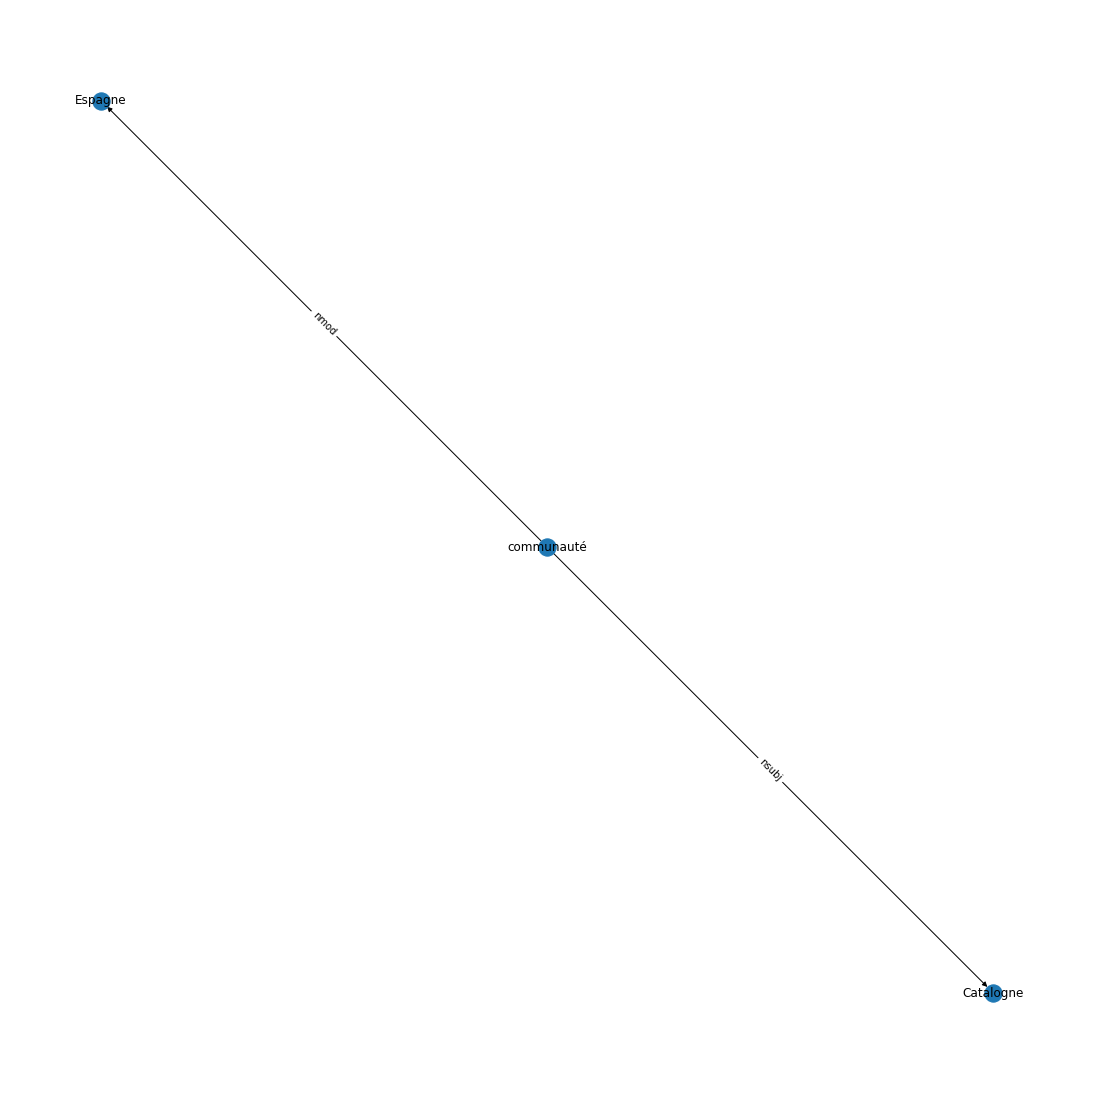

In [37]:
from utils.utils import vizGraph 
print(rule_dict['noAnchorMatch'][0])
vizGraph(rule_dict['noAnchorMatch'][0][-1]['sdpgraph'], label='text')

({'pred': 'Other', 'score': 0, 'rule': 'noPatternMatch', 'anchor': 16, 'anchortext': 'pays_NOUN'}, 'nextInBodyWater', {'sourceNode': 1, 'targetNode': 29, 'sdpgraph': <networkx.classes.digraph.DiGraph object at 0x7fb27b313ee0>, 'prop': 'P206', 'source': 'Japon', 'target': 'Pacifique', 'source_type': 'Property:P625', 'target_type': 'Property:P625'})


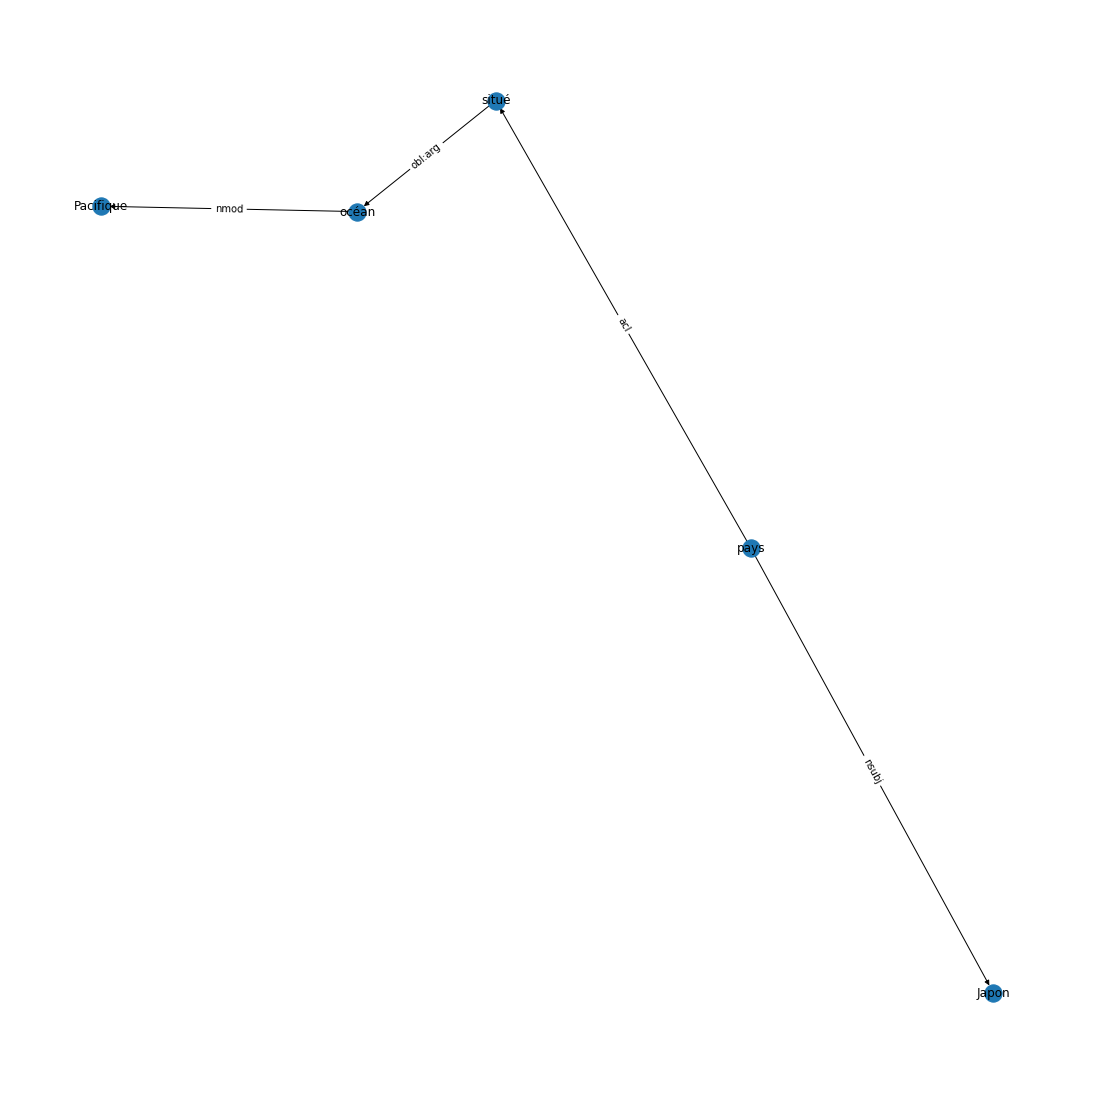

In [42]:
i = 4
print(rule_dict['noPatternMatch'][i])
vizGraph(rule_dict['noPatternMatch'][i][-1]['sdpgraph'], label='text')

({'pred': 'educatedAt', 'score': 0.41592011633562453, 'rule': 'semantic', 'anchor': 0, 'anchortext': 'devenir_VERB', 'candidate': {'nodes': [0, 1, 3], 'labels': [{'name': 'educatedAt', 'support': 2}], 'graph': <networkx.classes.digraph.DiGraph object at 0x7fb2cfa5d1c0>, 'source_types': ['Q5'], 'source_nodes': [3], 'target_types': ['Property:P625'], 'target_nodes': [1], 'ner_rules': {'educatedAt': {'source_type': 'Q5', 'target_type': 'Property:P625'}}}}, 'occupation', {'sourceNode': 3, 'targetNode': 1, 'sdpgraph': <networkx.classes.digraph.DiGraph object at 0x7fb27bca1130>, 'prop': 'P106', 'source': 'Louis IX', 'target': 'roi', 'source_type': 'Q5', 'target_type': 'Misc'})


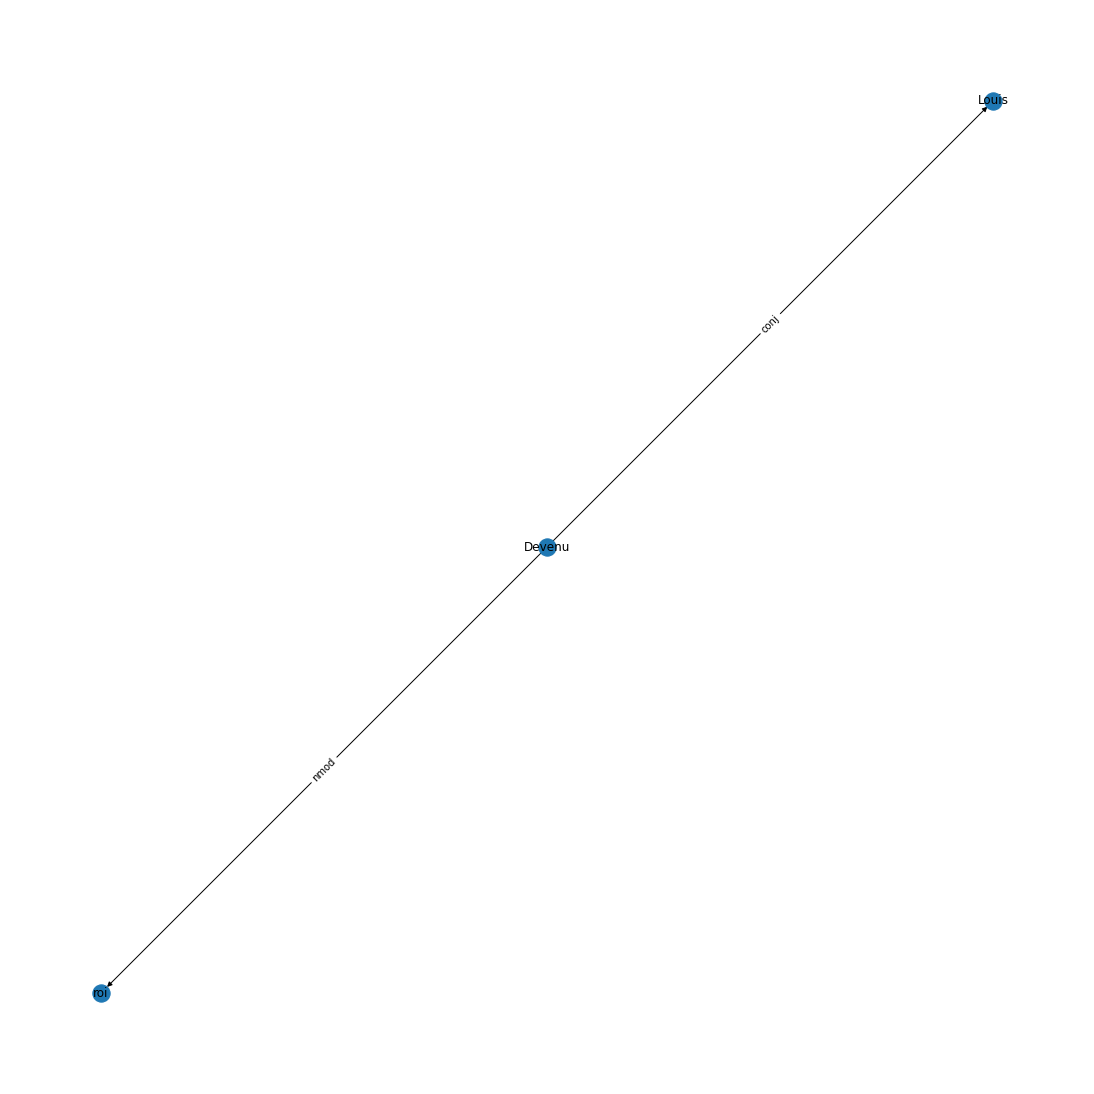

In [52]:
i = 10
print(rule_dict['semantic'][i])
vizGraph(rule_dict['semantic'][i][-1]['sdpgraph'], label='text')

({'pred': 'Other', 'score': 0.45870502701372556, 'rule': 'tooWeak', 'anchor': 3, 'anchortext': 'naître_VERB', 'candidate': {'nodes': [0, 3, 7], 'labels': [{'name': 'placeOfBirth', 'support': 11}], 'graph': <networkx.classes.digraph.DiGraph object at 0x7fb2cb7b4df0>, 'source_types': ['Q5'], 'source_nodes': [0], 'target_types': ['Property:P625'], 'target_nodes': [7], 'ner_rules': {'placeOfBirth': {'source_type': 'Q5', 'target_type': 'Property:P625'}}}}, 'placeOfBirth', {'sourceNode': 0, 'targetNode': 7, 'sdpgraph': <networkx.classes.digraph.DiGraph object at 0x7fb27be1d760>, 'prop': 'P19', 'source': 'Douglas Adams', 'target': 'Cambridge', 'source_type': 'Q5', 'target_type': 'Property:P625'})


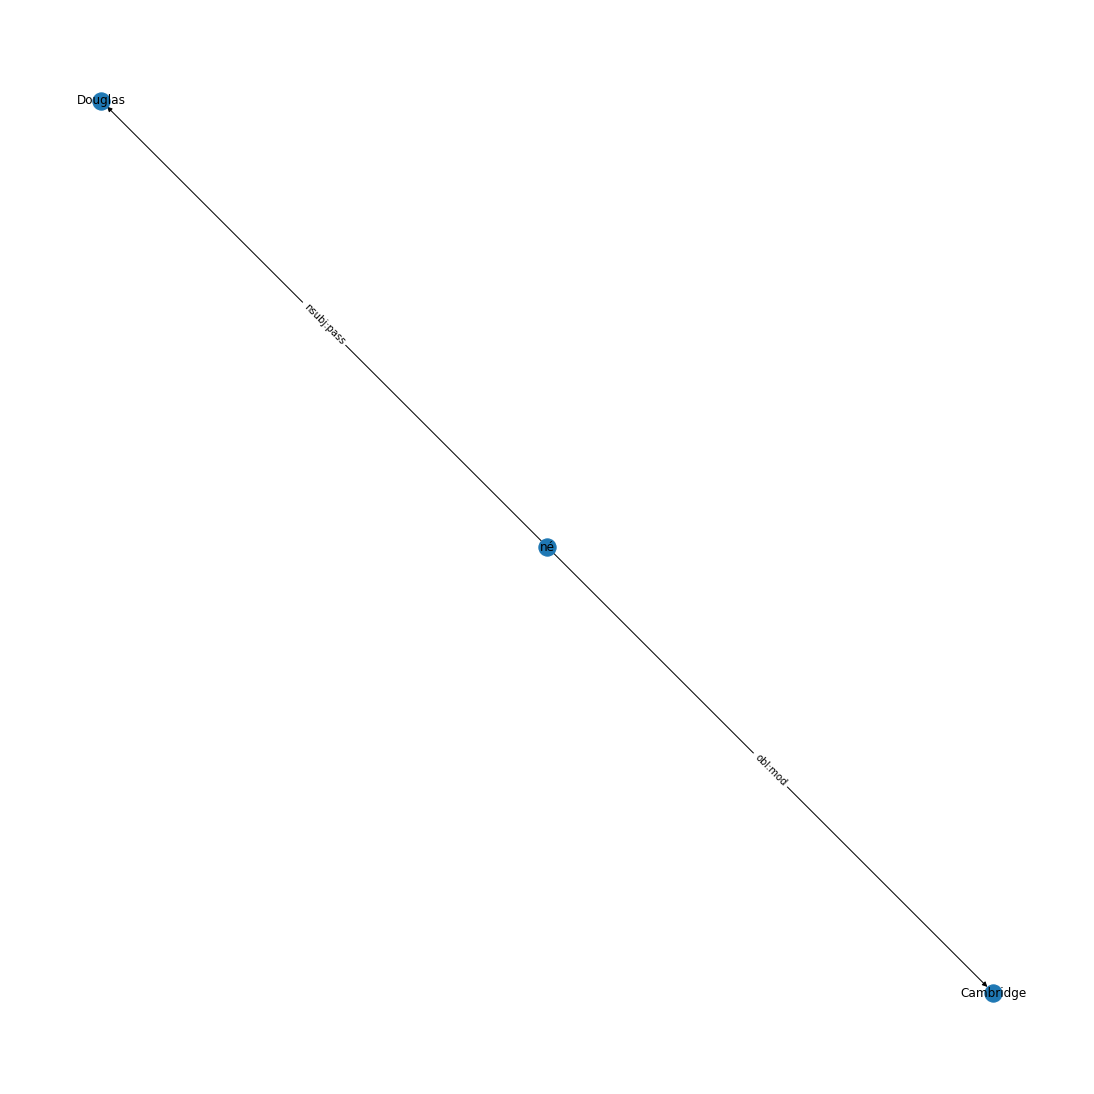

In [61]:
i = 1
print(rule_dict['tooWeak'][i])
vizGraph(rule_dict['tooWeak'][i][-1]['sdpgraph'], label='text')

In [87]:

def getScores(key_model):
    list_val = []
    index = []
    for j in eval_dict[key_model].keys():

        devPred = eval_dict[key_model][j]['testPred']
        devTrue = eval_dict[key_model][j]['trueTest']

        l_rules = []
        for x, y in zip(devPred, devTrue):
            if x['pred'] != y and y !='Other':
                l_rules.append(x['rule'])
                # print(x['pred'], y,  x['rule'], x['score'])

        c = Counter(l_rules)
        list_val.append(dict(c.most_common()))
        index.append(j)

    return pd.DataFrame(list_val, index=index)

key_model = 'base_semanticIndex'
print(getScores(key_model).to_latex())


# print()

\begin{tabular}{lrrrr}
\toprule
 & noAnchorMatch & noPatternMatch & semantic & tooWeak \\
\midrule
0.000000 & 263 & 158 & 13.000000 & 2 \\
0.100000 & 263 & 158 & 9.000000 & 9 \\
0.200000 & 263 & 158 & 9.000000 & 9 \\
0.300000 & 263 & 158 & 7.000000 & 17 \\
0.400000 & 263 & 158 & 7.000000 & 18 \\
0.500000 & 263 & 158 & 7.000000 & 27 \\
0.600000 & 263 & 158 & 7.000000 & 29 \\
0.700000 & 263 & 158 & 3.000000 & 35 \\
0.800000 & 263 & 158 & 3.000000 & 40 \\
0.900000 & 263 & 158 & NaN & 45 \\
\bottomrule
\end{tabular}



### Testing Semantic Index hyperparameters

In [31]:
semantic_index_params = [
    {
        "list_graphs": data['X_train'],
        "textvalue":  syntacticIndex.syntacticIndexParams['anchor_textvalue'],
        "min_weight": .7,
        "dict_prop": dict_prop,
    },
    {
        "list_graphs": data['X_train'],
        "textvalue":  syntacticIndex.syntacticIndexParams['anchor_textvalue'],
        "pos_filter": ('ADJ', 'NOUN', 'VERB', 'ADP', "AUX"),
        "dict_prop": dict_prop,
    },
    {
        "list_graphs": data['X_train'],
        "textvalue":  syntacticIndex.syntacticIndexParams['anchor_textvalue'],
        "pos_filter": ('ADJ', 'NOUN', 'VERB', 'ADP', "AUX"),
        "min_weight": .7,
        "dict_prop": dict_prop,
    },
]
models = {}
for i, params in enumerate(semantic_index_params):
    new_semanticIndex = SemanticIndex()
    new_semanticIndex.trainSemanticIndex(**params)
    models[f'semanticIndex{i}'] = IndexModel(extractor=syntacticIndex, classifier=new_semanticIndex)

In [32]:
# list_thresh = [0]
# dev_true_y = [tmp_dict[x] for x in evaldata['y_dev']]
# test_true_y = [tmp_dict[x] for x in evaldata['y_test']]
# # upper_bound = 1
# eval_dict = evaluate_models(models=models, evaldata=evaldata, dev_true_y=dev_true_y, test_true_y=test_true_y, list_thresh=list_thresh)

/Users/nicolasgutehrle/opt/anaconda3/envs/corpus/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolasgutehrle/opt/anaconda3/envs/corpus/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nicolasgutehrle/opt/anaconda3/envs/corpus/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

In [33]:
for key in models.keys():
    eval = showEval(eval_dict, key)

    
    print(eval.round(decimals=3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Dev} & \multicolumn{3}{l}{Test} \\
{} &      P &      R &     F1 &      P &      R &     F1 \\
\midrule
0 &  0.341 &  0.086 &  0.128 &  0.353 &  0.092 &  0.134 \\
1 &  0.341 &  0.086 &  0.128 &  0.353 &  0.092 &  0.134 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Dev} & \multicolumn{3}{l}{Test} \\
{} &      P &      R &     F1 &      P &      R &     F1 \\
\midrule
0 &  0.597 &  0.168 &  0.233 &  0.492 &  0.131 &  0.194 \\
1 &  0.597 &  0.168 &  0.233 &  0.492 &  0.131 &  0.194 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Dev} & \multicolumn{3}{l}{Test} \\
{} &      P &      R &     F1 &      P &      R &     F1 \\
\midrule
0 &  0.343 &  0.088 &  0.131 &  0.349 &  0.094 &  0.135 \\
1 &  0.343 &  0.088 &  0.131 &  0.349 &  0.094 &  0.135 \\
\bottomrule
\end{tabular}



## ML Classifiers

In [28]:
svc = SVC(probability=True)
svc.fit(X=vec_data['X_train'], y=vec_data['y_train'])

SVC(probability=True)

In [29]:
bagging = BaggingClassifier(tree.DecisionTreeClassifier(random_state=42))
bagging.fit(X=vec_data['X_train'], y=vec_data['y_train'])



BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42))

In [30]:
randomforest = RandomForestClassifier()

randomforest.fit(X=vec_data['X_train'], y=vec_data['y_train'])



RandomForestClassifier()

In [31]:
gbc = GradientBoostingClassifier(random_state=42)

gbc.fit(X=vec_data['X_train'], y=vec_data['y_train'])



GradientBoostingClassifier(random_state=42)

In [32]:
xgb_model = xgb.XGBClassifier(random_state=42)


xgb_model.fit(X=vec_data['X_train'], y=vec_data['y_train'])

XGBClassifier(objective='multi:softprob', random_state=42)

# Evaluation

In [33]:
ml_models = {
    "svc": IndexModel(extractor=syntacticIndex, classifier=svc, we=we),
    "bagging": IndexModel(extractor=syntacticIndex, classifier=bagging, we=we),
    "randomforest": IndexModel(extractor=syntacticIndex, classifier=randomforest, we=we),
    "gbc": IndexModel(extractor=syntacticIndex, classifier=gbc, we=we),
    "xgb_model": IndexModel(extractor=syntacticIndex, classifier=xgb_model, we=we)
}
list_thresh = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]

# upper_bound = 1
# ml_tmp_dict
# ml_eval_dict = evaluate_models(models=ml_models, evaldata=evaldata, dict_rel=ml_tmp_dict, dict_ent=dict_ent,ner_tags=tags, list_thresh=list_thresh)
ml_eval_dict = evaluate_models(models=ml_models, evaldata=evaldata, dict_rel=tmp_dict, dict_ent=dict_ent,ner_tags=tags, list_thresh=list_thresh)

/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classificati

In [40]:

for key in ml_eval_dict.keys():
    print(key)
    eval = showEval(ml_eval_dict, key)
    print(eval.round(decimals=3).to_latex())
# eval['test']

svc
\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{3}{r}{Dev} & \multicolumn{3}{r}{Test} \\
 & P & R & F1 & P & R & F1 \\
\midrule
0.000000 & 0.657000 & 0.154000 & 0.238000 & 0.613000 & 0.145000 & 0.226000 \\
0.100000 & 0.657000 & 0.154000 & 0.238000 & 0.613000 & 0.145000 & 0.226000 \\
0.200000 & 0.657000 & 0.154000 & 0.238000 & 0.618000 & 0.145000 & 0.228000 \\
0.300000 & 0.664000 & 0.154000 & 0.240000 & 0.666000 & 0.145000 & 0.234000 \\
0.400000 & 0.660000 & 0.143000 & 0.221000 & 0.668000 & 0.129000 & 0.209000 \\
0.500000 & 0.609000 & 0.138000 & 0.212000 & 0.637000 & 0.124000 & 0.200000 \\
0.600000 & 0.573000 & 0.135000 & 0.207000 & 0.580000 & 0.121000 & 0.194000 \\
0.700000 & 0.430000 & 0.116000 & 0.176000 & 0.437000 & 0.108000 & 0.171000 \\
0.800000 & 0.435000 & 0.113000 & 0.172000 & 0.452000 & 0.108000 & 0.172000 \\
0.900000 & 0.321000 & 0.069000 & 0.109000 & 0.286000 & 0.047000 & 0.077000 \\
10.000000 & 0.566000 & 0.133000 & 0.205000 & 0.557000 & 0.122000 & 0.194000 \\
\bottom

In [41]:

for key in ml_eval_dict.keys():
    print(key)
    eval = showEval(ml_eval_dict, key)
    print(eval.round(decimals=3))
# eval['test']

svc
        Dev                 Test              
          P      R     F1      P      R     F1
0.0   0.657  0.154  0.238  0.613  0.145  0.226
0.1   0.657  0.154  0.238  0.613  0.145  0.226
0.2   0.657  0.154  0.238  0.618  0.145  0.228
0.3   0.664  0.154  0.240  0.666  0.145  0.234
0.4   0.660  0.143  0.221  0.668  0.129  0.209
0.5   0.609  0.138  0.212  0.637  0.124  0.200
0.6   0.573  0.135  0.207  0.580  0.121  0.194
0.7   0.430  0.116  0.176  0.437  0.108  0.171
0.8   0.435  0.113  0.172  0.452  0.108  0.172
0.9   0.321  0.069  0.109  0.286  0.047  0.077
10.0  0.566  0.133  0.205  0.557  0.122  0.194
bagging
        Dev                 Test              
          P      R     F1      P      R     F1
0.0   0.667  0.154  0.238  0.628  0.145  0.227
0.1   0.674  0.154  0.241  0.646  0.145  0.232
0.2   0.674  0.154  0.241  0.681  0.145  0.235
0.3   0.674  0.154  0.241  0.681  0.145  0.235
0.4   0.674  0.154  0.241  0.681  0.145  0.235
0.5   0.701  0.141  0.220  0.695  0.129  0.211
0

### Best model

In [32]:
xgb_params = {
    "n_estimators": [50, 100, 150, 200, 350, 500],
    "max_depth": [i for i in range(1, 11)],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
    "subsample": [.25, .5, .75, 1],
    "random_state": [42]

}

xgb_grid = RandomizedSearchCV(estimator=xgb.XGBClassifier(), param_distributions=xgb_params, n_jobs=-1, verbose=3)
xgb_grid.fit(X=vec_data['X_train'], y=vec_data['y_train'])
xgb_grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.0001, max_depth=10, n_estimators=100, random_state=42, subsample=1;, score=0.470 total time= 6.3min
[CV 3/5] END learning_rate=0.0001, max_depth=10, n_estimators=100, random_state=42, subsample=1;, score=0.468 total time= 6.5min
[CV 2/5] END learning_rate=0.0001, max_depth=10, n_estimators=100, random_state=42, subsample=1;, score=0.385 total time= 7.0min
[CV 1/5] END learning_rate=0.1, max_depth=4, n_estimators=350, random_state=42, subsample=0.5;, score=0.559 total time= 8.3min
[CV 4/5] END learning_rate=0.1, max_depth=4, n_estimators=350, random_state=42, subsample=0.5;, score=0.569 total time= 8.3min
[CV 3/5] END learning_rate=0.1, max_depth=4, n_estimators=350, random_state=42, subsample=0.5;, score=0.573 total time= 8.3min
[CV 5/5] END learning_rate=0.1, max_depth=4, n_estimators=350, random_state=42, subsample=0.5;, score=0.576 total time= 8.4min
[CV 2/5] END learning_rate=0.1, max_depth=4,

{'subsample': 0.5,
 'random_state': 42,
 'n_estimators': 350,
 'max_depth': 4,
 'learning_rate': 0.1}

In [14]:
xgb_params = {'subsample': 0.5,
 'random_state': 42,
 'n_estimators': 350,
 'max_depth': 4,
 'learning_rate': 0.1}

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X=vec_data['X_train'], y=vec_data['y_train'])

KeyboardInterrupt: 

In [ ]:
import joblib
os.makedirs(f"{project}/model/mlClassifier", exist_ok=True)

joblib.dump(xgb_model, f"{project}/model/mlClassifier/clf.joblib")

['../data/Q5-Property:P625/model/mlClassifier/clf.joblib']

In [34]:
bagging_params = {
    "n_estimators": [10, 50, 100, 150, 200],
    "max_samples": [.25, .5, .75, 1],
    'max_features': [.25, .5, .75, 1]
}
boosting_grid = RandomizedSearchCV(estimator=BaggingClassifier(), param_distributions=bagging_params, n_jobs=-2)
boosting_grid.fit(X=vec_data['X_train'], y=vec_data['y_train'])
boosting_grid.best_params_

{'n_estimators': 150, 'max_samples': 0.75, 'max_features': 0.75}

In [50]:
# bagging_best_params = {'n_estimators': 200, 'max_samples': 0.5, 'max_features': 0.75}
bagging_best_params = {'n_estimators': 150, 'max_samples': 0.75, 'max_features': 0.75}


bagging = BaggingClassifier(**bagging_best_params)

bagging.fit(X=vec_data['X_train'], y=vec_data['y_train'])



BaggingClassifier(max_features=0.75, max_samples=0.75, n_estimators=150)

In [36]:
os.makedirs(f"{project}/model/mlClassifier", exist_ok=True)

joblib.dump(bagging, f"{project}/model/mlClassifier/clf.joblib")

['../data/Q5-Property:P625/model/mlClassifier/clf.joblib']

In [43]:
rf_params = {
    "n_estimators": [100, 150, 200, 250, 300],
    "criterion": ['gini',"entropy", "log_loss"],
    "max_depth": [None, 3,6,9,12],
    "max_features": ['sqrt','log2', None],
    "bootstrap": [True, False],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, n_jobs=6, verbose=3)
rf_grid = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_params, n_jobs=-2)
rf_grid.fit(X=vec_data['X_train'], y=vec_data['y_train'])
rf_grid.best_params_

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'gini',
 'bootstrap': True}

In [44]:
rf_grid.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'gini',
 'bootstrap': True}

In [45]:
rf_best_params = {'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'gini',
 'bootstrap': True}

rf = RandomForestClassifier(**rf_best_params)

rf.fit(X=vec_data['X_train'], y=vec_data['y_train'])

RandomForestClassifier(max_depth=12, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=150)

In [46]:
os.makedirs(f"{project}/model/mlClassifier", exist_ok=True)

joblib.dump(bagging, f"{project}/model/mlClassifier/clf.joblib")

['../data/Q5-Property:P625/model/mlClassifier/clf.joblib']

In [52]:
ml_models = {
    "xgb": IndexModel(extractor=syntacticIndex, classifier=xgb_model, we=we),
    "bagging": IndexModel(extractor=syntacticIndex, classifier=bagging, we=we),
    "rf": IndexModel(extractor=syntacticIndex, classifier=rf, we=we),

}
list_thresh = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
ml_eval_dict = evaluate_models(models=ml_models, evaldata=evaldata, dict_rel=tmp_dict, dict_ent=dict_ent,ner_tags=tags, list_thresh=list_thresh)
# dev_true_y = [tmp_dict[x] for x in evaldata['y_dev']]
# test_true_y = [tmp_dict[x] for x in evaldata['y_test']]

# eval_dict = evaluate_models(models=models, evaldata=evaldata, dev_true_y=dev_true_y, test_true_y=test_true_y, list_thresh=list_thresh)

/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classificati

In [89]:
for key in ml_eval_dict.keys():
    print(key)
    eval = showEval(ml_eval_dict, key)
    print(eval.round(decimals=3).to_latex())
# eval['test']

xgb
\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{3}{r}{Dev} & \multicolumn{3}{r}{Test} \\
 & P & R & F1 & P & R & F1 \\
\midrule
0.000000 & 0.667000 & 0.154000 & 0.238000 & 0.628000 & 0.145000 & 0.227000 \\
0.100000 & 0.674000 & 0.154000 & 0.241000 & 0.646000 & 0.145000 & 0.232000 \\
0.200000 & 0.674000 & 0.154000 & 0.241000 & 0.681000 & 0.145000 & 0.235000 \\
0.300000 & 0.674000 & 0.154000 & 0.241000 & 0.681000 & 0.145000 & 0.235000 \\
0.400000 & 0.674000 & 0.154000 & 0.241000 & 0.681000 & 0.145000 & 0.235000 \\
0.500000 & 0.705000 & 0.145000 & 0.227000 & 0.693000 & 0.131000 & 0.215000 \\
0.600000 & 0.701000 & 0.130000 & 0.204000 & 0.695000 & 0.120000 & 0.196000 \\
0.700000 & 0.701000 & 0.129000 & 0.201000 & 0.695000 & 0.118000 & 0.193000 \\
0.800000 & 0.650000 & 0.124000 & 0.192000 & 0.664000 & 0.115000 & 0.187000 \\
0.900000 & 0.650000 & 0.124000 & 0.192000 & 0.664000 & 0.115000 & 0.187000 \\
10.000000 & 0.677000 & 0.142000 & 0.222000 & 0.673000 & 0.133000 & 0.214000 \\
\bottom

In [54]:
print(ml_eval_dict['xgb'][0.5]['dev']['report'])

                   precision    recall  f1-score   support

            Other      0.000     0.000     0.000         0
        capitalOf      0.714     0.071     0.130        70
          country      0.556     0.051     0.093        99
      dateOfBirth      1.000     0.250     0.400        40
      dateOfDeath      1.000     0.150     0.261        20
       educatedAt      0.600     0.375     0.462         8
  headOfGoverment      0.500     0.143     0.222         7
        inception      1.000     0.143     0.250         7
         memberOf      1.000     0.121     0.216        33
  nextInBodyWater      0.750     0.130     0.222        23
       occupation      1.000     0.315     0.479        73
     placeOfBirth      1.000     0.032     0.062        31
sharesBordersWith      0.000     0.000     0.000        76
           spouse      0.750     0.250     0.375        12

         accuracy                          0.124       499
        macro avg      0.705     0.145     0.227      

In [55]:
print(ml_eval_dict['xgb'][0.5]['test']['report'])

                   precision    recall  f1-score   support

            Other      0.000     0.000     0.000         0
        capitalOf      0.429     0.042     0.077        71
          country      0.778     0.081     0.147        86
      dateOfBirth      1.000     0.152     0.263        33
      dateOfDeath      1.000     0.261     0.414        23
       educatedAt      1.000     0.200     0.333         5
  headOfGoverment      1.000     0.125     0.222         8
        inception      0.000     0.000     0.000         5
         memberOf      1.000     0.250     0.400        20
  nextInBodyWater      0.500     0.071     0.125        28
       occupation      1.000     0.302     0.463        63
     placeOfBirth      1.000     0.056     0.105        36
sharesBordersWith      0.000     0.000     0.000       109
           spouse      1.000     0.300     0.462        10

         accuracy                          0.109       497
        macro avg      0.693     0.131     0.215      

In [81]:

for w,x,y,z in zip(ml_eval_dict['bagging'][0]['devPred'],ml_eval_dict['bagging'][0]['trueDev'],ml_eval_dict['bagging'][0]['devNerPred'],ml_eval_dict['bagging'][0]['devNerTrue']):
    # if w['pred'] != x:
        # if w['pred'] != 'Other':
            # if y != z:
            # # if y:
            #     print(w['pred'], x)
            #     print(y)
            #     print(z)
            #     print()

    if y:
        if y != z:
            print(y)
            print(z)
            print( )
    # if w['pred'] == 'Other':
    #     if  y:
    #         print(y)


[{'label': 'LOC', 'start': 7, 'end': 8}, {'label': 'LOC', 'start': 1, 'end': 2}]
[{'label': 'LOC', 'start': 1, 'end': 2}, {'label': 'LOC', 'start': 7, 'end': 8}]

[{'label': 'LOC', 'start': 0, 'end': 1}, {'label': 'LOC', 'start': 11, 'end': 12}]
[{'label': 'LOC', 'start': 0, 'end': 1}, {'label': 'LOC', 'start': 11, 'end': 14}]

[{'label': 'PER', 'start': 6, 'end': 8}, {'label': 'TIME', 'start': 13, 'end': 15}]
[{'label': 'PER', 'start': 6, 'end': 8}, {'label': 'TIME', 'start': 13, 'end': 16}]

[{'label': 'LOC', 'start': 0, 'end': 1}, {'label': 'LOC', 'start': 11, 'end': 12}]
[{'label': 'LOC', 'start': 0, 'end': 1}, {'label': 'LOC', 'start': 11, 'end': 14}]

[{'label': 'PER', 'start': 5, 'end': 7}, {'label': 'TIME', 'start': 16, 'end': 18}]
[{'label': 'PER', 'start': 5, 'end': 7}, {'label': 'TIME', 'start': 16, 'end': 19}]

[{'label': 'PER', 'start': 0, 'end': 2}, {'label': 'TIME', 'start': 11, 'end': 13}]
[{'label': 'PER', 'start': 0, 'end': 2}, {'label': 'TIME', 'start': 11, 'end': 14

In [58]:
dev_df_ner = pd.concat([nereval2df(ml_eval_dict['xgb'][x]['devNer'], name=x) for x in ml_eval_dict['xgb'].keys()])
test_df_ner = pd.concat([nereval2df(ml_eval_dict['xgb'][x]['testNer'], name=x) for x in ml_eval_dict['xgb'].keys()])
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
 &  & Pleft_ & Rleft_ & F1left_ & Pright_ & Rright_ & F1right_ \\
model & eval &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.000000} & ent_type & 0.959000 & 0.163000 & 0.279000 & 0.974000 & 0.149000 & 0.258000 \\
 & partial & 0.844000 & 0.144000 & 0.246000 & 0.849000 & 0.130000 & 0.225000 \\
 & strict & 0.665000 & 0.113000 & 0.193000 & 0.678000 & 0.104000 & 0.180000 \\
 & exact & 0.688000 & 0.117000 & 0.200000 & 0.697000 & 0.107000 & 0.185000 \\
\cline{1-8}
\multirow[t]{4}{*}{0.100000} & ent_type & 0.970000 & 0.163000 & 0.280000 & 1.000000 & 0.149000 & 0.259000 \\
 & partial & 0.845000 & 0.142000 & 0.244000 & 0.848000 & 0.126000 & 0.220000 \\
 & strict & 0.673000 & 0.113000 & 0.194000 & 0.696000 & 0.104000 & 0.180000 \\
 & exact & 0.690000 & 0.116000 & 0.199000 & 0.696000 & 0.104000 & 0.180000 \\
\cline{1-8}
\multirow[t]{4}{*}{0.200000} & ent_type & 0.970000 & 0.163000 & 0.280000 & 1.000000 & 0.147000 & 0.256000 \\
 & partial & 0.845000 & 0.14200

In [57]:
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').groupby('eval').mean().round(decimals=3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
 & Pleft_ & Rleft_ & F1left_ & Pright_ & Rright_ & F1right_ \\
eval &  &  &  &  &  &  \\
\midrule
ent_type & 0.963000 & 0.136000 & 0.238000 & 0.997000 & 0.122000 & 0.215000 \\
exact & 0.700000 & 0.099000 & 0.172000 & 0.687000 & 0.084000 & 0.149000 \\
partial & 0.850000 & 0.120000 & 0.209000 & 0.843000 & 0.103000 & 0.182000 \\
strict & 0.678000 & 0.096000 & 0.167000 & 0.685000 & 0.084000 & 0.148000 \\
\bottomrule
\end{tabular}



In [59]:
dev_df_ner = pd.concat([nerevaltype2df(ml_eval_dict['xgb'][x]['devNerType'], name=x) for x in ml_eval_dict['xgb'].keys()])
test_df_ner = pd.concat([nerevaltype2df(ml_eval_dict['xgb'][x]['testNerType'], name=x) for x in ml_eval_dict['xgb'].keys()])
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llllllllll}
\toprule
 &  & PERleft_ & LOCleft_ & TIMEleft_ & MISCleft_ & PERright_ & LOCright_ & TIMEright_ & MISCright_ \\
model & eval &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.000000} & ent_type & 0.414062 & 0.199181 & 0.345679 & 0.469388 & 0.400000 & 0.187583 & 0.305556 & 0.463415 \\
 & partial & 0.363281 & 0.188267 & 0.209877 & 0.397959 & 0.340426 & 0.180978 & 0.166667 & 0.353659 \\
 & strict & 0.312500 & 0.155525 & 0.074074 & 0.265306 & 0.280851 & 0.155878 & 0.027778 & 0.243902 \\
 & exact & 0.312500 & 0.163711 & 0.074074 & 0.285714 & 0.280851 & 0.163804 & 0.027778 & 0.243902 \\
\cline{1-10}
\multirow[t]{4}{*}{0.100000} & ent_type & 0.414062 & 0.199726 & 0.345679 & 0.469388 & 0.400000 & 0.188579 & 0.305556 & 0.463415 \\
 & partial & 0.363281 & 0.184679 & 0.209877 & 0.397959 & 0.340426 & 0.172643 & 0.166667 & 0.353659 \\
 & strict & 0.312500 & 0.155951 & 0.074074 & 0.265306 & 0.280851 & 0.156707 & 0.027778 & 0.243902 \\
 & exact & 0.312500 & 0.161423

In [61]:


def getScores(key_model):
    list_val = []
    index = []
    for j in ml_eval_dict[key_model].keys():

        devPred = ml_eval_dict[key_model][j]['devPred']
        devTrue = ml_eval_dict[key_model][j]['trueDev']

        l_rules = []
        for x, y in zip(devPred, devTrue):
            if x['pred'] != y and y !='Other':
                l_rules.append(x['rule'])
                # print(x['pred'], y,  x['rule'], x['score'])

        c = Counter(l_rules)
        list_val.append(dict(c.most_common()))
        index.append(j)

    return pd.DataFrame(list_val, index=index)

key_model = 'xgb'
print(getScores(key_model).to_latex())

# print()

\begin{tabular}{lrrrr}
\toprule
 & noAnchorMatch & noPatternMatch & semantic & tooWeak \\
\midrule
0.000000 & 246 & 168 & 19 & NaN \\
0.100000 & 246 & 168 & 18 & 1.000000 \\
0.200000 & 246 & 168 & 18 & 1.000000 \\
0.300000 & 246 & 168 & 18 & 1.000000 \\
0.400000 & 246 & 168 & 18 & 1.000000 \\
0.500000 & 246 & 168 & 15 & 8.000000 \\
0.600000 & 246 & 168 & 13 & 20.000000 \\
0.700000 & 246 & 168 & 13 & 21.000000 \\
0.800000 & 246 & 168 & 11 & 28.000000 \\
0.900000 & 246 & 168 & 11 & 28.000000 \\
\bottomrule
\end{tabular}



In [62]:

def getScores(key_model):
    list_val = []
    index = []
    for j in ml_eval_dict[key_model].keys():

        devPred = ml_eval_dict[key_model][j]['testPred']
        devTrue = ml_eval_dict[key_model][j]['trueTest']

        l_rules = []
        for x, y in zip(devPred, devTrue):
            if x['pred'] != y and y !='Other':
                l_rules.append(x['rule'])
                # print(x['pred'], y,  x['rule'], x['score'])

        c = Counter(l_rules)
        list_val.append(dict(c.most_common()))
        index.append(j)

    return pd.DataFrame(list_val, index=index)

key_model = 'xgb'
print(getScores(key_model).to_latex())

# print()

\begin{tabular}{lrrrr}
\toprule
 & noAnchorMatch & noPatternMatch & semantic & tooWeak \\
\midrule
0.000000 & 263 & 158 & 15 & NaN \\
0.100000 & 263 & 158 & 13 & 2.000000 \\
0.200000 & 263 & 158 & 12 & 3.000000 \\
0.300000 & 263 & 158 & 12 & 3.000000 \\
0.400000 & 263 & 158 & 12 & 3.000000 \\
0.500000 & 263 & 158 & 11 & 11.000000 \\
0.600000 & 263 & 158 & 10 & 19.000000 \\
0.700000 & 263 & 158 & 10 & 20.000000 \\
0.800000 & 263 & 158 & 6 & 27.000000 \\
0.900000 & 263 & 158 & 6 & 27.000000 \\
\bottomrule
\end{tabular}



# Evaluation on EMONTAL dataset

In [63]:
emontal_project = '../data/emontal-ner-er/'
clean = True
emontal_corpus = loadCorpus(emontal_project, clean=clean)
len(emontal_corpus), emontal_corpus[0]

(1,
 {'id': 1,
  'content': [{'sent': 'Robespierre le jeune fut envoyé en mission dans le département de la llauleSaône au mois de mai 1704, trois mois à peu près avant le 0 Thermidor.',
    'props': [{'prop': 'Other',
      'sent': 'Robespierre le jeune fut envoyé en mission dans le département de la llauleSaône au mois de mai 1704, trois mois à peu près avant le 0 Thermidor.',
      'source': 'NO-SOURCE',
      'target': 'NO-TARGET',
      'sdpgraphs': [{'sourceNode': None,
        'targetNode': None,
        'sourceNodeRoot': None,
        'targetNodeRoot': None,
        'sdpgraph': <networkx.classes.digraph.DiGraph at 0x1f8b1bf10>}]}],
    'sent_i': 1,
    'head': 4,
    'graph': <networkx.classes.digraph.DiGraph at 0x1f80cbb50>},
   {'sent': 'Bernard était un homme de cinq pieds neuf pouces, d’une cinquantaine d’années, dont la taille était droite et très menue, le port roide et assuré, la physionomie d’une imperturbable austérité que n’avait jamais égarée un sourire.',
    'props

In [64]:
params = {
    "corpus": emontal_corpus,
    "train_size": .5,
    "dev_size": 0,
    "clean": True
    # "maxsize": 200000
}
emontal_evaldata = prepare_corpus(**params)
print(len(emontal_evaldata['X_dev']), len(emontal_evaldata['X_test']))

197 198


In [65]:
from collections import Counter 

c = Counter([x['prop'] for x in emontal_evaldata['X_test']])
print(pd.Series(dict(c.most_common())).to_frame().to_latex())

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
Other & 62 \\
occupation & 31 \\
placeOfBirth & 27 \\
dateOfBirth & 18 \\
dateOfDeath & 13 \\
sharesBordersWith & 12 \\
spouse & 11 \\
memberOf & 9 \\
educatedAt & 7 \\
inception & 6 \\
capitalOf & 2 \\
\bottomrule
\end{tabular}



In [66]:
models = {
    "base_semanticIndex": IndexModel(extractor=syntacticIndex, classifier=base_semanticIndex),    
    # "bagging": IndexModel(extractor=syntacticIndex, classifier=bagging, we=we),
    "xgb": IndexModel(extractor=syntacticIndex, classifier=xgb_model, we=we),

}


list_thresh = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
# emontal_dev_true_y = emontal_evaldata['y_dev']
# emontal_test_true_y = emontal_evaldata['y_test']
# upper_bound = 1
emontal_eval_dict = evaluate_models(models=models, evaldata=emontal_evaldata,dict_ent=dict_ent, ner_tags=tags,list_thresh=list_thresh)

/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Volumes/T7/.conda/lib/python3.11/site-packages/sklearn/metrics/_classific

In [70]:

for key in emontal_eval_dict.keys():
    print(key)
    eval = showEval(emontal_eval_dict, key)
    print(eval.round(decimals=3).to_latex())
# eval['test']

base_semanticIndex
\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{3}{r}{Dev} & \multicolumn{3}{r}{Test} \\
 & P & R & F1 & P & R & F1 \\
\midrule
0.000000 & 0.560000 & 0.227000 & 0.298000 & 0.523000 & 0.186000 & 0.244000 \\
0.100000 & 0.560000 & 0.227000 & 0.298000 & 0.523000 & 0.186000 & 0.244000 \\
0.200000 & 0.560000 & 0.227000 & 0.298000 & 0.523000 & 0.186000 & 0.244000 \\
0.300000 & 0.393000 & 0.102000 & 0.156000 & 0.523000 & 0.140000 & 0.207000 \\
0.400000 & 0.393000 & 0.102000 & 0.156000 & 0.523000 & 0.140000 & 0.207000 \\
0.500000 & 0.333000 & 0.079000 & 0.122000 & 0.455000 & 0.110000 & 0.165000 \\
0.600000 & 0.250000 & 0.071000 & 0.107000 & 0.455000 & 0.110000 & 0.165000 \\
0.700000 & 0.250000 & 0.071000 & 0.107000 & 0.455000 & 0.110000 & 0.165000 \\
0.800000 & 0.167000 & 0.029000 & 0.050000 & 0.364000 & 0.069000 & 0.109000 \\
0.900000 & 0.167000 & 0.029000 & 0.050000 & 0.364000 & 0.069000 & 0.109000 \\
10.000000 & 0.363000 & 0.116000 & 0.164000 & 0.470000 & 0.131000 & 0.18

In [71]:
print(emontal_eval_dict['base_semanticIndex'][0]['dev']['report'])

                   precision    recall  f1-score   support

            Other      0.000     0.000     0.000         0
        capitalOf      0.000     0.000     0.000         2
          country      1.000     0.667     0.800         3
      dateOfBirth      1.000     0.438     0.609        16
      dateOfDeath      1.000     0.235     0.381        17
       educatedAt      0.000     0.000     0.000         8
        inception      1.000     0.833     0.909        12
         memberOf      0.000     0.000     0.000         7
       occupation      0.000     0.000     0.000        31
     placeOfBirth      0.714     0.278     0.400        18
sharesBordersWith      1.000     0.100     0.182        10
           spouse      1.000     0.174     0.296        23

         accuracy                          0.224       147
        macro avg      0.560     0.227     0.298       147
     weighted avg      0.638     0.224     0.309       147



In [72]:
print(emontal_eval_dict['base_semanticIndex'][0]['test']['report'])

                   precision    recall  f1-score   support

            Other      0.000     0.000     0.000         0
        capitalOf      0.000     0.000     0.000         2
      dateOfBirth      1.000     0.444     0.615        18
      dateOfDeath      1.000     0.308     0.471        13
       educatedAt      0.000     0.000     0.000         7
        inception      1.000     0.833     0.909         6
         memberOf      0.000     0.000     0.000         9
       occupation      1.000     0.032     0.062        31
     placeOfBirth      0.750     0.333     0.462        27
sharesBordersWith      0.000     0.000     0.000        12
           spouse      1.000     0.091     0.167        11

         accuracy                          0.206       136
        macro avg      0.523     0.186     0.244       136
     weighted avg      0.730     0.206     0.286       136



In [73]:
print(emontal_eval_dict['xgb'][0]['dev']['report'])

                   precision    recall  f1-score   support

            Other      0.000     0.000     0.000         0
        capitalOf      0.000     0.000     0.000         2
          country      1.000     0.667     0.800         3
      dateOfBirth      1.000     0.438     0.609        16
      dateOfDeath      1.000     0.235     0.381        17
       educatedAt      0.000     0.000     0.000         8
        inception      1.000     0.833     0.909        12
         memberOf      0.000     0.000     0.000         7
       occupation      0.000     0.000     0.000        31
     placeOfBirth      0.714     0.278     0.400        18
sharesBordersWith      1.000     0.100     0.182        10
           spouse      1.000     0.174     0.296        23

         accuracy                          0.224       147
        macro avg      0.560     0.227     0.298       147
     weighted avg      0.638     0.224     0.309       147



In [74]:
print(emontal_eval_dict['xgb'][0]['test']['report'])

                   precision    recall  f1-score   support

            Other      0.000     0.000     0.000         0
        capitalOf      0.000     0.000     0.000         2
      dateOfBirth      1.000     0.444     0.615        18
      dateOfDeath      1.000     0.308     0.471        13
       educatedAt      0.000     0.000     0.000         7
        inception      1.000     0.833     0.909         6
         memberOf      0.000     0.000     0.000         9
       occupation      1.000     0.032     0.062        31
     placeOfBirth      0.750     0.333     0.462        27
sharesBordersWith      0.000     0.000     0.000        12
           spouse      1.000     0.091     0.167        11

         accuracy                          0.206       136
        macro avg      0.523     0.186     0.244       136
     weighted avg      0.730     0.206     0.286       136



In [75]:
dev_df_ner = pd.concat([nereval2df(emontal_eval_dict['base_semanticIndex'][x]['devNer'], name=x) for x in emontal_eval_dict['base_semanticIndex'].keys()])
test_df_ner = pd.concat([nereval2df(emontal_eval_dict['base_semanticIndex'][x]['testNer'], name=x) for x in emontal_eval_dict['base_semanticIndex'].keys()])
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
 &  & Pleft_ & Rleft_ & F1left_ & Pright_ & Rright_ & F1right_ \\
model & eval &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.000000} & ent_type & 0.838000 & 0.211000 & 0.337000 & 0.721000 & 0.180000 & 0.288000 \\
 & partial & 0.818000 & 0.206000 & 0.329000 & 0.809000 & 0.202000 & 0.324000 \\
 & strict & 0.527000 & 0.133000 & 0.212000 & 0.397000 & 0.099000 & 0.159000 \\
 & exact & 0.635000 & 0.160000 & 0.255000 & 0.618000 & 0.154000 & 0.247000 \\
\cline{1-8}
\multirow[t]{4}{*}{0.100000} & ent_type & 0.838000 & 0.211000 & 0.337000 & 0.721000 & 0.180000 & 0.288000 \\
 & partial & 0.818000 & 0.206000 & 0.329000 & 0.809000 & 0.202000 & 0.324000 \\
 & strict & 0.527000 & 0.133000 & 0.212000 & 0.397000 & 0.099000 & 0.159000 \\
 & exact & 0.635000 & 0.160000 & 0.255000 & 0.618000 & 0.154000 & 0.247000 \\
\cline{1-8}
\multirow[t]{4}{*}{0.200000} & ent_type & 0.838000 & 0.211000 & 0.337000 & 0.721000 & 0.180000 & 0.288000 \\
 & partial & 0.818000 & 0.20600

In [76]:
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').groupby('eval').mean().round(decimals=3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
 & Pleft_ & Rleft_ & F1left_ & Pright_ & Rright_ & F1right_ \\
eval &  &  &  &  &  &  \\
\midrule
ent_type & 0.880000 & 0.132000 & 0.224000 & 0.833000 & 0.135000 & 0.227000 \\
exact & 0.626000 & 0.098000 & 0.165000 & 0.575000 & 0.101000 & 0.169000 \\
partial & 0.813000 & 0.127000 & 0.213000 & 0.788000 & 0.137000 & 0.228000 \\
strict & 0.538000 & 0.082000 & 0.138000 & 0.438000 & 0.071000 & 0.120000 \\
\bottomrule
\end{tabular}



In [77]:
dev_df_ner = pd.concat([nerevaltype2df(emontal_eval_dict['base_semanticIndex'][x]['devNerType'], name=x) for x in emontal_eval_dict['base_semanticIndex'].keys()])
test_df_ner = pd.concat([nerevaltype2df(emontal_eval_dict['base_semanticIndex'][x]['testNerType'], name=x) for x in emontal_eval_dict['base_semanticIndex'].keys()])
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llllllllll}
\toprule
 &  & PERleft_ & LOCleft_ & TIMEleft_ & MISCleft_ & PERright_ & LOCright_ & TIMEright_ & MISCright_ \\
model & eval &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.000000} & ent_type & 0.261905 & 0.383838 & 0.626866 & 0 & 0.273973 & 0.209524 & 0.629630 & 0.057143 \\
 & partial & 0.244048 & 0.424242 & 0.507463 & 0.117647 & 0.287671 & 0.342857 & 0.462963 & 0.200000 \\
 & strict & 0.166667 & 0.242424 & 0.388060 & 0 & 0.136986 & 0.152381 & 0.296296 & 0.057143 \\
 & exact & 0.178571 & 0.343434 & 0.388060 & 0.117647 & 0.205479 & 0.304762 & 0.296296 & 0.171429 \\
\cline{1-10}
\multirow[t]{4}{*}{0.100000} & ent_type & 0.261905 & 0.383838 & 0.626866 & 0 & 0.273973 & 0.209524 & 0.629630 & 0.057143 \\
 & partial & 0.244048 & 0.424242 & 0.507463 & 0.117647 & 0.287671 & 0.342857 & 0.462963 & 0.200000 \\
 & strict & 0.166667 & 0.242424 & 0.388060 & 0 & 0.136986 & 0.152381 & 0.296296 & 0.057143 \\
 & exact & 0.178571 & 0.343434 & 0.388060 & 0.117647 & 0.2

In [78]:
dev_df_ner = pd.concat([nereval2df(emontal_eval_dict['xgb'][x]['devNer'], name=x) for x in emontal_eval_dict['xgb'].keys()])
test_df_ner = pd.concat([nereval2df(emontal_eval_dict['xgb'][x]['testNer'], name=x) for x in emontal_eval_dict['xgb'].keys()])
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
 &  & Pleft_ & Rleft_ & F1left_ & Pright_ & Rright_ & F1right_ \\
model & eval &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.000000} & ent_type & 0.838000 & 0.211000 & 0.337000 & 0.721000 & 0.180000 & 0.288000 \\
 & partial & 0.818000 & 0.206000 & 0.329000 & 0.809000 & 0.202000 & 0.324000 \\
 & strict & 0.527000 & 0.133000 & 0.212000 & 0.397000 & 0.099000 & 0.159000 \\
 & exact & 0.635000 & 0.160000 & 0.255000 & 0.618000 & 0.154000 & 0.247000 \\
\cline{1-8}
\multirow[t]{4}{*}{0.100000} & ent_type & 0.838000 & 0.211000 & 0.337000 & 0.721000 & 0.180000 & 0.288000 \\
 & partial & 0.818000 & 0.206000 & 0.329000 & 0.809000 & 0.202000 & 0.324000 \\
 & strict & 0.527000 & 0.133000 & 0.212000 & 0.397000 & 0.099000 & 0.159000 \\
 & exact & 0.635000 & 0.160000 & 0.255000 & 0.618000 & 0.154000 & 0.247000 \\
\cline{1-8}
\multirow[t]{4}{*}{0.200000} & ent_type & 0.838000 & 0.211000 & 0.337000 & 0.721000 & 0.180000 & 0.288000 \\
 & partial & 0.818000 & 0.20600

In [79]:
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').groupby('eval').mean().round(decimals=3).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
 & Pleft_ & Rleft_ & F1left_ & Pright_ & Rright_ & F1right_ \\
eval &  &  &  &  &  &  \\
\midrule
ent_type & 0.897000 & 0.180000 & 0.296000 & 0.757000 & 0.141000 & 0.234000 \\
exact & 0.648000 & 0.131000 & 0.216000 & 0.627000 & 0.117000 & 0.194000 \\
partial & 0.824000 & 0.167000 & 0.275000 & 0.813000 & 0.153000 & 0.254000 \\
strict & 0.571000 & 0.114000 & 0.188000 & 0.442000 & 0.081000 & 0.134000 \\
\bottomrule
\end{tabular}



In [80]:
dev_df_ner = pd.concat([nerevaltype2df(emontal_eval_dict['xgb'][x]['devNerType'], name=x) for x in emontal_eval_dict['xgb'].keys()])
test_df_ner = pd.concat([nerevaltype2df(emontal_eval_dict['xgb'][x]['testNerType'], name=x) for x in emontal_eval_dict['xgb'].keys()])
print(dev_df_ner.join(test_df_ner, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llllllllll}
\toprule
 &  & PERleft_ & LOCleft_ & TIMEleft_ & MISCleft_ & PERright_ & LOCright_ & TIMEright_ & MISCright_ \\
model & eval &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{0.000000} & ent_type & 0.261905 & 0.383838 & 0.626866 & 0 & 0.273973 & 0.209524 & 0.629630 & 0.057143 \\
 & partial & 0.244048 & 0.424242 & 0.507463 & 0.117647 & 0.287671 & 0.342857 & 0.462963 & 0.200000 \\
 & strict & 0.166667 & 0.242424 & 0.388060 & 0 & 0.136986 & 0.152381 & 0.296296 & 0.057143 \\
 & exact & 0.178571 & 0.343434 & 0.388060 & 0.117647 & 0.205479 & 0.304762 & 0.296296 & 0.171429 \\
\cline{1-10}
\multirow[t]{4}{*}{0.100000} & ent_type & 0.261905 & 0.383838 & 0.626866 & 0 & 0.273973 & 0.209524 & 0.629630 & 0.057143 \\
 & partial & 0.244048 & 0.424242 & 0.507463 & 0.117647 & 0.287671 & 0.342857 & 0.462963 & 0.200000 \\
 & strict & 0.166667 & 0.242424 & 0.388060 & 0 & 0.136986 & 0.152381 & 0.296296 & 0.057143 \\
 & exact & 0.178571 & 0.343434 & 0.388060 & 0.117647 & 0.2

In [81]:
def getScores(key_model):
    list_val = []
    index = []
    for j in emontal_eval_dict[key_model].keys():

        devPred = emontal_eval_dict[key_model][j]['devPred']
        devTrue = emontal_eval_dict[key_model][j]['trueDev']

        l_rules = []
        for x, y in zip(devPred, devTrue):
            if x['pred'] != y and y !='Other':
                l_rules.append(x['rule'])
                # print(x['pred'], y,  x['rule'], x['score'])

        c = Counter(l_rules)
        list_val.append(dict(c.most_common()))
        index.append(j)

    return pd.DataFrame(list_val, index=index)

key_model = 'base_semanticIndex'
print(getScores(key_model).to_latex())

# print()

\begin{tabular}{lrrrr}
\toprule
 & noAnchorMatch & noPatternMatch & semantic & tooWeak \\
\midrule
0.000000 & 70 & 40 & 4.000000 & NaN \\
0.100000 & 70 & 40 & 4.000000 & NaN \\
0.200000 & 70 & 40 & 4.000000 & NaN \\
0.300000 & 70 & 40 & 4.000000 & 12.000000 \\
0.400000 & 70 & 40 & 4.000000 & 12.000000 \\
0.500000 & 70 & 40 & 2.000000 & 19.000000 \\
0.600000 & 70 & 40 & 2.000000 & 20.000000 \\
0.700000 & 70 & 40 & 2.000000 & 20.000000 \\
0.800000 & 70 & 40 & 1.000000 & 29.000000 \\
0.900000 & 70 & 40 & NaN & 30.000000 \\
\bottomrule
\end{tabular}



In [82]:


def getScores(key_model):
    list_val = []
    index = []
    for j in emontal_eval_dict[key_model].keys():

        devPred = emontal_eval_dict[key_model][j]['testPred']
        devTrue = emontal_eval_dict[key_model][j]['trueTest']

        l_rules = []
        for x, y in zip(devPred, devTrue):
            if x['pred'] != y and y !='Other':
                l_rules.append(x['rule'])
                # print(x['pred'], y,  x['rule'], x['score'])

        c = Counter(l_rules)
        list_val.append(dict(c.most_common()))
        index.append(j)

    return pd.DataFrame(list_val, index=index)

key_model = 'base_semanticIndex'
print(getScores(key_model).to_latex())

# print()

\begin{tabular}{lrrrr}
\toprule
 & noAnchorMatch & noPatternMatch & semantic & tooWeak \\
\midrule
0.000000 & 58 & 44 & 6.000000 & NaN \\
0.100000 & 58 & 44 & 6.000000 & NaN \\
0.200000 & 58 & 44 & 6.000000 & NaN \\
0.300000 & 58 & 44 & 6.000000 & 3.000000 \\
0.400000 & 58 & 44 & 6.000000 & 3.000000 \\
0.500000 & 58 & 44 & 2.000000 & 16.000000 \\
0.600000 & 58 & 44 & 2.000000 & 16.000000 \\
0.700000 & 58 & 44 & 2.000000 & 16.000000 \\
0.800000 & 58 & 44 & 1.000000 & 25.000000 \\
0.900000 & 58 & 44 & NaN & 26.000000 \\
\bottomrule
\end{tabular}



In [83]:

def getScores(key_model):
    list_val = []
    index = []
    for j in emontal_eval_dict[key_model].keys():

        devPred = emontal_eval_dict[key_model][j]['devPred']
        devTrue = emontal_eval_dict[key_model][j]['trueDev']

        l_rules = []
        for x, y in zip(devPred, devTrue):
            if x['pred'] != y and y !='Other':
                l_rules.append(x['rule'])
                # print(x['pred'], y,  x['rule'], x['score'])

        c = Counter(l_rules)
        list_val.append(dict(c.most_common()))
        index.append(j)

    return pd.DataFrame(list_val, index=index)

key_model = 'xgb'
print(getScores(key_model).to_latex())

# print()

\begin{tabular}{lrrrr}
\toprule
 & noAnchorMatch & noPatternMatch & semantic & tooWeak \\
\midrule
0.000000 & 70 & 40 & 4 & NaN \\
0.100000 & 70 & 40 & 4 & NaN \\
0.200000 & 70 & 40 & 4 & NaN \\
0.300000 & 70 & 40 & 4 & NaN \\
0.400000 & 70 & 40 & 4 & NaN \\
0.500000 & 70 & 40 & 2 & 7.000000 \\
0.600000 & 70 & 40 & 2 & 16.000000 \\
0.700000 & 70 & 40 & 2 & 16.000000 \\
0.800000 & 70 & 40 & 2 & 16.000000 \\
0.900000 & 70 & 40 & 2 & 16.000000 \\
\bottomrule
\end{tabular}



In [84]:
def getScores(key_model):
    list_val = []
    index = []
    for j in emontal_eval_dict[key_model].keys():

        devPred = emontal_eval_dict[key_model][j]['testPred']
        devTrue = emontal_eval_dict[key_model][j]['trueTest']

        l_rules = []
        for x, y in zip(devPred, devTrue):
            if x['pred'] != y and y !='Other':
                l_rules.append(x['rule'])
                # print(x['pred'], y,  x['rule'], x['score'])

        c = Counter(l_rules)
        list_val.append(dict(c.most_common()))
        index.append(j)

    return pd.DataFrame(list_val, index=index)

key_model = 'xgb'
print(getScores(key_model).to_latex())


# print()

\begin{tabular}{lrrrr}
\toprule
 & noAnchorMatch & noPatternMatch & semantic & tooWeak \\
\midrule
0.000000 & 58 & 44 & 6 & NaN \\
0.100000 & 58 & 44 & 6 & NaN \\
0.200000 & 58 & 44 & 6 & NaN \\
0.300000 & 58 & 44 & 6 & NaN \\
0.400000 & 58 & 44 & 6 & NaN \\
0.500000 & 58 & 44 & 4 & 10.000000 \\
0.600000 & 58 & 44 & 4 & 18.000000 \\
0.700000 & 58 & 44 & 4 & 18.000000 \\
0.800000 & 58 & 44 & 4 & 18.000000 \\
0.900000 & 58 & 44 & 4 & 19.000000 \\
\bottomrule
\end{tabular}



In [33]:
import spacy 

nlp = spacy.load('fr_core_news_lg')

In [37]:
with open('/Volumes/T7/THESE/CORPUS/CORPUS-TEST/corpus_pompon.txt') as f:
    test_data = f.read()
    test_data = test_data.split('\n')
    test_data = [x for x in test_data if x]

with open('/Volumes/T7/THESE/CORPUS/CORPUS-TEST/corpus_saulieu.txt') as f:
    test_data2 = f.read()
    test_data2 = test_data2.split('\n')
    test_data2 = [x for x in test_data2 if x]

test_data = test_data + test_data2
test_data

['François Pompon hors texte).',
 'Ceux cependant qui connaissent François Pompon, m accorderont que cet homme les rassemble toutes.',
 'faisait éclater les bourgeons de la vigne, lorsqu à isaulieu naquit en 1855 François Pompon.',
 'Alais nous attendons mieux, car sa vie sobre et laborieuse lui a conservé un tempérament et une activité très jeunes qui nous permettent espérer toute la gloire à laquelle François Pompon a droit.',
 'Le numéro du et décembre de 1 ’j4rt Vivant, consacre deux pages avec photo et trois reproductions) à notre dévoué membre d’honneur, François Pompon, le sculpteur animalier si justement réputé.',
 '— Cette très belle revue qui se spécialise de plus en plus dans l’archéologie et l’histoire, donne dans son compterendu des livres, sous la signature de Pierre Tartat, des lignes fort prenantes sur François Pompon.',
 'Notre VI Salon, qui ouvrira ses portes quand paraîtra ce numéro de notre Revue, marquera encore un progrès sur les précédents, tant par le nombre des

In [35]:
test_corpus = map(nlppipe.process_doc, data)

# [nlppipe.process_doc(x) for x in data]

NameError: name 'nlppipe' is not defined

In [40]:
import re 
from glob import glob 

sent_re = re.compile(r'<sent[^>]*>([^</]*)')
test_data = []

for filepath in glob('/Volumes/T7/THESE/CORPUS/**/**_docbook.xml', recursive=True)[:50]:
    # print(filepath)
    with open(filepath, encoding='utf-8') as f:
        file = f.read()
    r = sent_re.findall(file)
    for span in r:
        span = span.strip()
        test_data.append(span)
    # break

In [41]:
extractor = IndexModel(extractor=syntacticIndex, classifier=base_semanticIndex)
fuzzyMatch = True
thresh = 0

test_corpus = nlp.pipe(test_data)

for i, doc in enumerate(test_corpus):

    f = extractor.extractFacts(doc, fuzzyMatch=fuzzyMatch, thresh=thresh)
    if f:
        print(doc)

        for x in f:
            print(x)
        print()

    # if doc.spans['FACTS']:

    #     print(i, doc)

    #     print('ENT')
    #     for ent in doc.ents:
    #         print(ent, ent.label_)

    #     for time in doc.spans['TIMEX']:
    #         print(time, time.label_)
            
    #     print('FACTS')
    #     for fact in doc.spans['FACTS']:
    #         print(fact, fact.label_)

    # break

Sous avons de même puisé dans cette chronique, également véridique, mais de tendance contraire à celles des trois auteurs précités, qui étaient légitimistes, alors que Pérusson fut un des chefs de l'opposition au gouvernement de Juillet, el que, en mai 1848, il devint souscommissaire provisoire du gouvernement {sous-préfet) à Chalon, en remplacement de son ami, E. Menand, qui venait d'être élu représentant du peuple à l'Assemblée constituante.
{'fact': {'pred': 'educatedAt', 'score': 0.4560809084525051, 'rule': 'semantic', 'anchor': 50, 'anchortext': 'devenir_VERB', 'candidate': {'nodes': [50, 59, 46], 'labels': [{'name': 'educatedAt', 'support': 2}], 'graph': <networkx.classes.digraph.DiGraph object at 0x7fe8d4bec250>, 'source_types': ['Q5'], 'source_nodes': [59], 'target_types': ['Property:P625'], 'target_nodes': [46], 'ner_rules': {'educatedAt': {'source_type': 'Q5', 'target_type': 'Property:P625'}}}}, 'ner': [{'pred': 'Q5', 'root_node': 59, 'start': 59, 'end': 60, 'char_start': 328

KeyboardInterrupt: 

In [32]:
text = 'Pierre est orthiculteur'
# text = 'Paris est la capitale de la France'
text = 'Pierre est né à Paris le 14 juillet 1789'
# text = 'Besancon est situé au nord de la France'
# text = 'Besancon fait partie de la France'
# text = 'Harry épouse Franck'
# text = 'Harry époux de Franck'
# text = 'Harry Pierre mourru le 15 septembre 1890'

doc = nlp(text)

fuzzyMatch = True
thresh = 0

extractor = IndexModel(extractor=syntacticIndex, classifier=base_semanticIndex)
f = extractor.extractFacts(doc, fuzzyMatch=fuzzyMatch, thresh=thresh)
for x in f:
    print(x)

cc {'anchorNode': 2, 'anchorText': 'naître_VERB', 'candidate': {'nodes': [0, 2, 4], 'labels': [{'name': 'placeOfBirth', 'support': 14}, {'name': 'placeOfBirth', 'support': 29}, {'name': 'placeOfBirth', 'support': 5}, {'name': 'placeOfBirth', 'support': 11}, {'name': 'placeOfBirth', 'support': 2}], 'graph': <networkx.classes.digraph.DiGraph object at 0x7fe8692b67c0>}}
cc {'anchorNode': 2, 'anchorText': 'naître_VERB', 'candidate': {'nodes': [0, 2, 6], 'labels': [{'name': 'dateOfBirth', 'support': 101}, {'name': 'dateOfDeath', 'support': 11}, {'name': 'dateOfBirth', 'support': 23}, {'name': 'dateOfDeath', 'support': 5}, {'name': 'dateOfBirth', 'support': 17}, {'name': 'dateOfBirth', 'support': 2}], 'graph': <networkx.classes.digraph.DiGraph object at 0x7fe8692b6ee0>}}
{'fact': {'pred': 'placeOfBirth', 'score': 0.4312103248721664, 'rule': 'semantic', 'anchor': 2, 'anchortext': 'naître_VERB', 'candidate': {'nodes': [0, 2, 4], 'labels': [{'name': 'placeOfBirth', 'support': 14}], 'graph': <ne

In [140]:
from spacy import displacy

displacy.serve(doc)

OSError: [Errno 48] Address already in use